# Imports

In [1]:
!nvidia-smi

Mon Oct 23 09:33:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   31C    P8    20W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
torch.__version__

'1.12.1+cu116'

In [3]:
!pip install -U albumentations[imgaug]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 39.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 99.2 MB/s eta 0:00:00


In [4]:
!pip -q install timm
!pip -q install efficientnet_pytorch
!pip -q install albumentations --upgrade
!pip install "opencv-python-headless<4.3"
#!pip install opencv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 31.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.


In [5]:
%%capture
!git clone https://github.com/NVIDIA/apex
!cd apex && pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

In [6]:
use_apex = False

try:
    from apex import amp as apex_amp
    use_apex = True
except ImportError:
    pass

use_apex

False

In [7]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch
import timm
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import numpy as np
import albumentations as A
from torch.nn import Module,Sequential
import gc
import cv2
from albumentations.augmentations.transforms import Lambda
import IPython.display as ipd
import requests
import io
import urllib.parse

In [8]:
import random
import numpy as np
SEED_VAL  = 1000
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED = SEED_VAL):
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  os.environ['PYTHONHASHSEED'] = str(SEED)
  torch.backends.cudnn.deterministic = True

In [9]:
import timm
from pprint import pprint
# model_names = timm.list_models(pretrained=True)
# pprint(model_names)

# CONF

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class conf:
  train_batch_size = 64
  learning_rate = 1e-3
  model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
  num_classes = 1
  epochs = 25
  nfolds = 5
  use_folds = [0,1,2,3,4]
  use_finetuned = False
  path_model = "*"
  use_tta = False
  tta_iterations = 5
  use_scheduler = True
  workers = os.cpu_count()
def get_default_conf():
    return conf

CONF = get_default_conf()

# Donwload Data and Read it

In [11]:
# Read in csv files.
main_path = "/storage/cgiar-eyes-data/"
train = pd.read_csv(main_path+'/Train.csv')
test = pd.read_csv(main_path+'/Test.csv')
sample_submission = pd.read_csv(main_path+'/SampleSubmission.csv')
train.shape,test.shape

((26068, 6), (8663, 5))

In [12]:
train.head()

,ID,filename,growth_stage,damage,extent,season
0,ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020
1,ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021
2,ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020
3,ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020
4,ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021


In [13]:
train.extent.value_counts()

0      21558
10       729
30       727
40       696
20       690
50       445
60       388
90       300
80       291
70       199
100       45
Name: extent, dtype: int64

In [14]:
train.season.value_counts(normalize=True)

SR2021    0.380812
LR2021    0.304780
SR2020    0.236420
LR2020    0.077988
Name: season, dtype: float64

In [15]:
test.head()

,ID,filename,growth_stage,damage,season
0,ID_ROOWKB90UZ,L122F00315C01S02151Rp04021.jpg,V,WD,SR2020
1,ID_PTEDRY0CYM,L1089F03254C01S08845Rp25119.jpg,F,WD,LR2021
2,ID_5WJXDV96R4,L365F01913C39S12578Rp42918.jpg,V,WD,SR2021
3,ID_DM4AQLXXYG,223_repeat_2_2230_3599_2343.JPG,F,G,LR2020
4,ID_V6YTIT7I2S,L354F00276C01S08045Rp23693.jpg,F,G,LR2021


In [16]:
test.season.value_counts(normalize=True)

SR2021    0.372042
LR2021    0.308784
SR2020    0.239294
LR2020    0.079880
Name: season, dtype: float64

In [17]:
sample_submission.head()

,ID,extent
0,ID_KJ12GE2U80,0
1,ID_W33POE3DBX,0
2,ID_1DZ7VKQTS9,0
3,ID_BAA59RN8RS,0
4,ID_45QA45VTEJ,0


In [18]:
train.shape, test.shape, sample_submission.shape

((26068, 6), (8663, 5), (8663, 2))

# Cross Validate

In [19]:
def cross_validate(train_orig,nfolds=CONF.nfolds):
  train = train_orig.copy()
  train['kfold'] = -1
  #get only 30 new turtle ( can add costraint of number images >= x , 10 for example)
  skf = StratifiedKFold(CONF.nfolds,random_state=SEED_VAL,shuffle=True)
  label_split = train[['growth_stage', 'season', 'extent']].apply(lambda x: '_'.join(list(map(str, x))), axis=1)
  for i,(train_index,val_index) in enumerate(skf.split(train,y=label_split)):
    train.loc[val_index,'kfold'] = i
  return train

In [20]:
train = cross_validate(train)
train.head()

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,ID,filename,growth_stage,damage,extent,season,kfold
0,ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020,1
1,ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021,0
2,ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020,3
3,ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,4
4,ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021,1


In [21]:
train[train.kfold == 0].extent.mean(),train[train.kfold == 1].extent.mean()

(7.0694284618335255, 7.061756808592252)

In [22]:
# train.extent = (train.extent * 10 ).astype('int')
# train.extent.value_counts()

# Modeling

In [23]:
import cv2
def default_image_loader(path):
    return Image.open(path).convert('RGB')

def cv_reader(path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

class ImageDataset(Dataset):
    def __init__(self, data_path, df, transform=None,mode='train'):
        self.df = df
        self.loader = cv_reader
        self.transform = transform
        self.dir = data_path
        self.mode = mode

    def __getitem__(self, index):
        image_id = self.df.filename[index]
        image = self.loader(os.path.join(self.dir, image_id))
        if self.transform is not None:
          image = self.transform(image=image)
          image=image["image"]


        if self.mode == 'train':
            label = self.df.extent[index]
            return {'image' : torch.tensor(image,dtype=torch.float),
                'label' : torch.tensor(label,dtype = torch.float) }

        return {'image' : torch.tensor(image,dtype=torch.float),
}


    def __len__(self):
        return self.df.shape[0]

In [24]:
class Net(nn.Module):
    def __init__(self,name,NUM_CLASSES):
        super(Net, self).__init__()
        self.name  = name
        if name == 'b0':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b0')
          self.arch._fc = nn.Linear(in_features=1280, out_features=NUM_CLASSES, bias=True)
        elif name == 'b1':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b1')
          self.arch._fc = nn.Linear(in_features=1280, out_features=NUM_CLASSES, bias=True)
        elif name == 'b2':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b2')
          self.arch._fc = nn.Linear(in_features=1408, out_features=NUM_CLASSES, bias=True)
        elif name =='b3':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b3')
          self.arch._fc = nn.Linear(in_features=1536, out_features=NUM_CLASSES, bias=True)
        elif name =='b4':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b4')
          self.arch._fc = nn.Linear(in_features=1792, out_features=NUM_CLASSES, bias=True)
        elif name =='b5':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b5')
          self.arch._fc = nn.Linear(in_features=2048, out_features=NUM_CLASSES, bias=True)
        elif name =='b6':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b6')
          self.arch._fc = nn.Linear(in_features=2304, out_features=NUM_CLASSES, bias=True)
        elif name =='b7':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b7')
          self.arch._fc = nn.Linear(in_features=2560, out_features=NUM_CLASSES, bias=True)
        elif name=='efficientnetv2_rw_m':
          self.arch = timm.create_model(name,pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.classifier = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'densenet121':
          self.arch = models.densenet121(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'densenet169':
          self.arch = models.densenet169(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'densenet201':
          self.arch = models.densenet201(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet18':
          self.arch = models.resnet18(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet50':
          self.arch = models.resnet50(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet101':
          self.arch = models.resnet101(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet152':
          self.arch = models.resnet152(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet34':
          self.arch = models.resnet34(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnext101':
          self.arch = models.resnext101_32x8d(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnext50':
          self.arch = models.resnext50_32x4d(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif 'swin' in name:
          self.arch = timm.create_model(name,pretrained=True)
          num_ftrs = self.arch.head.in_features
          self.arch.head = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif 'convnext' in name:
          self.arch = timm.create_model(name,pretrained=True)
          num_ftrs = self.arch.head.fc.in_features
          self.arch.head.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        else:
          self.arch  = timm.create_model(name, num_classes=1, pretrained=True)

    def forward(self, x):
        """
        """
        x = self.arch(x)
        return x

In [25]:
class AverageMeter():
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
def loss_fn(outputs,targets):
  criterion =  torch.nn.MSELoss()
  return criterion(outputs,targets)

In [27]:
!pip -q install accelerate
from accelerate import Accelerator

In [28]:
def train_fn(train_data_loader,model,optimizer,device,accelerator,scheduler):
  model.train()
  tot_loss = 0
  loss_meter = AverageMeter()
  tepoch = tqdm(enumerate(train_data_loader),total=len(train_data_loader))
  for bi,d in tepoch:
    images = d['image']
    labels = d['label']

    #send them to device
    # images = images.to(device,dtype=torch.float)
    # labels = labels.to(device,dtype=torch.float)
    outputs  = model(torch.permute(images,(0,3,1,2)))
    outputs = outputs.reshape(outputs.size()[0])
    loss = loss_fn(outputs,labels)
    if use_apex:
      with apex_amp.scale_loss(loss, optimizer) as scaled_loss:
          scaled_loss.backward()
    else:
      accelerator.backward(loss)
#     loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_meter.update(loss.item())
    tepoch.set_postfix(average_rmse=np.sqrt(loss_meter.avg))
    tot_loss = tot_loss + loss.item()
    if scheduler is not None:
        scheduler.step()
  mse_score = tot_loss/len(train_data_loader)
  return np.sqrt(mse_score)

def eval_fn(valid_data_loader,model,device):
  model.eval()
  tot_loss = 0
  all_outputs = []
  all_labels = []
  with torch.no_grad():
    for bi,d in enumerate(valid_data_loader):
      images = d['image']
      labels = d['label']
      #send them to device
      # images = images.to(device,dtype=torch.float)
      # labels = labels.to(device,dtype=torch.float)
      outputs  = model(torch.permute(images,(0,3,1,2)))
      outputs = outputs.reshape(outputs.size()[0])
      all_outputs.extend(outputs.detach().cpu().numpy())
      all_labels.extend(labels.detach().cpu().numpy())
      loss = loss_fn(outputs,labels)
      tot_loss = tot_loss + loss.item()

    all_outputs = np.array(all_outputs)
    mse_score  = tot_loss/len(valid_data_loader)
    return np.sqrt(mse_score)

In [29]:
HEIGHT = 384
WIDTH = 384
def get_transforms():
    train_transform = A.Compose(
        [
            #CustomAlbImageCropTransform(xmin=0.1, ymin=0.1, xmax=0.9, ymax=0.9, p=0.6),
            #A.Normalize(),
            A.Resize(height=HEIGHT, width=WIDTH, p=1),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ), 
            A.CoarseDropout(
                min_holes=1,
                max_holes=4,
                max_height=0.25,
                max_width=0.25,
                min_height=0.15,
                min_width=0.15,
                p = 0.25,
            ),
            A.Flip(p=0.25),
            A.RandomRotate90(p=0.25),
            A.Blur(p=0.1),
            # A.OneOf([
            #     A.RandomBrightnessContrast(p=1),
            #     A.RandomBrightness(p=1),
            #     A.HueSaturationValue(p=1),
            #     A.GaussianBlur(p=1),
            #     A.Blur(p=1),
            #     A.Sharpen(p=1),
            # ],p=0.2)
            
            #A.Sharpen(p=0.2),
            
#             A.OneOf([
#                 A.Blur(p=1),
#                 A.MedianBlur(p=1, blur_limit=5),
#                 A.GaussianBlur(p=1),
#                 A.GaussNoise(p=1),
#                 A.IAAAdditiveGaussianNoise(p=1),
#             ], p = 0.7),
#             A.OneOf([
#                 A.ColorJitter(p=1),
#                 A.RandomContrast(p=1),
#                 A.RandomGamma(p=1),
#                 A.RandomBrightness(p=1),
#             ], p = 0.7),
#             A.OneOf([
#                 A.ChannelShuffle(p=1),
#                 A.HueSaturationValue(p=1),
#                 A.JpegCompression(p=1),
#                 A.RGBShift(p=1),
#                 A.ToGray(p=1)
#             ], p = 0.55),
#             A.OneOf([
#                 A.OpticalDistortion(p=0.3),
#                 A.GridDistortion(p=0.1),
#                 A.IAAPiecewiseAffine(p=0.3),
#             ], p=0.2),
#             A.OneOf([
#                 A.CLAHE(clip_limit=2),
#                 A.IAASharpen(),
#                 A.IAAEmboss(),
#                 A.RandomBrightnessContrast(),
#             ], p=0.3),
        ],
        p=1.0,
    )

    val_transform = A.Compose([
      A.Resize(HEIGHT,WIDTH),
      A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
      ])

    return train_transform,val_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label[1]: 0.0
25


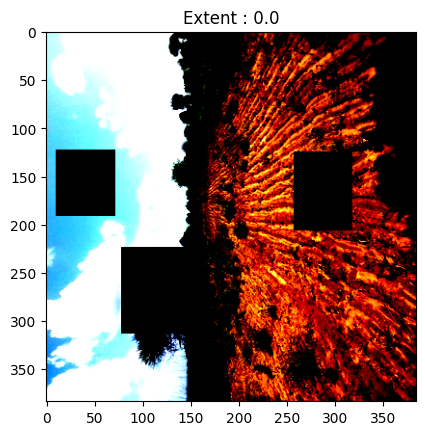

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


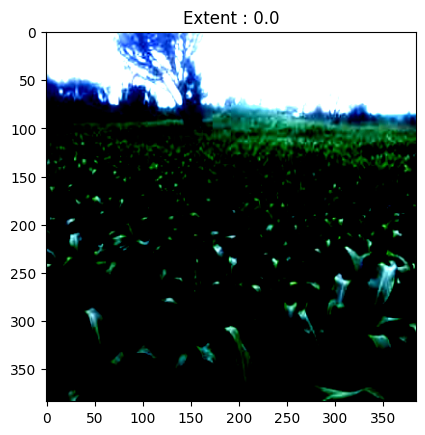

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


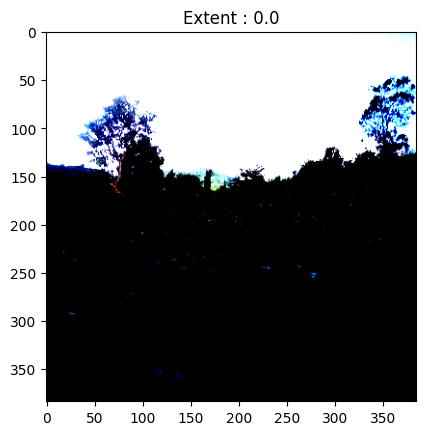

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


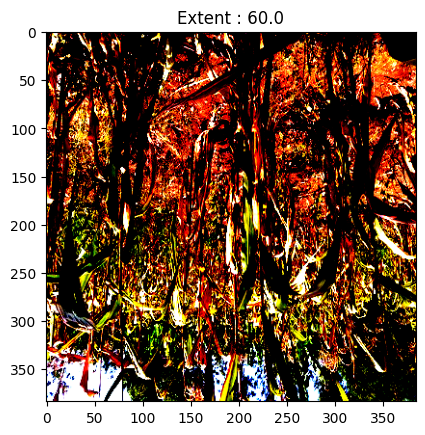

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


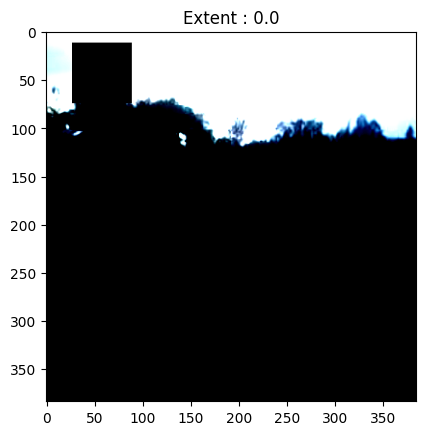

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


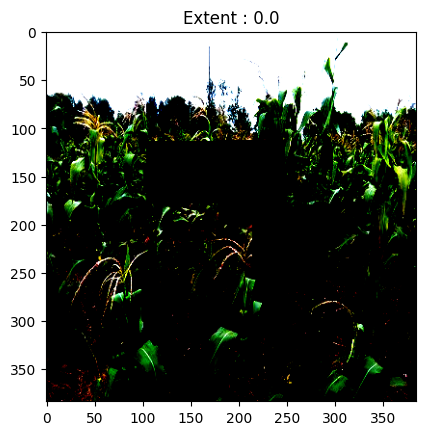

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


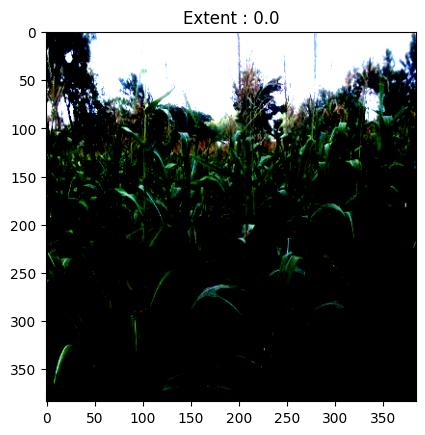

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


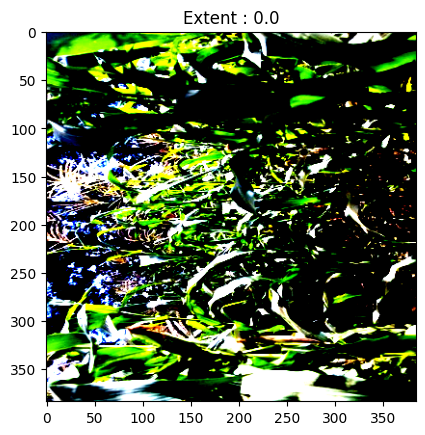

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


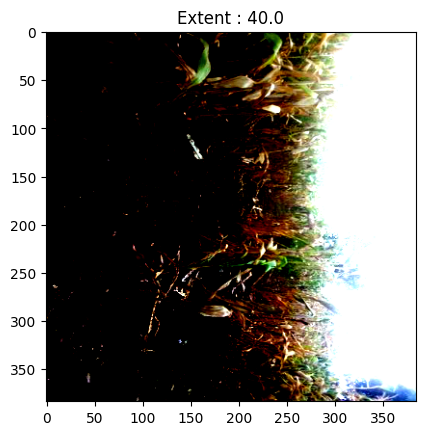

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


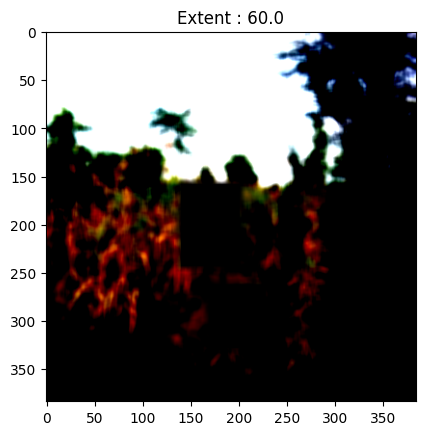

In [30]:
def image_show(data_loader,n):

  #Read Augmented image data
  a = next(iter(data_loader))
  #Convert image from tensor to numpy
  images = a['image'].numpy()
  labels = a['label'].numpy()
  print('label[1]:',labels[1])
  print(len(images))
  #Take out n images one by one and display them
  for i in range(n):
    image = images[i]
    image = np.transpose(image,[0,1,2])
    plt.imshow(image)
    plt.title(f'Extent : {labels[i]}')
    plt.show()


train_transform,_ = get_transforms()
test_images_dataset =  ImageDataset(main_path+'/train',train.head(50).reset_index(drop=True),train_transform)
test_images_loader = DataLoader(dataset=test_images_dataset,shuffle=False,batch_size=25)
image_show(test_images_loader,10)

In [31]:
def get_pretrained():
  model = timm.create_model(CONF.model_name,pretrained=False)
  in_features = model.head.in_features
  model.head =  nn.Linear(in_features, 512)
  model.load_state_dict(torch.load(CONF.path_model))
  model = nn.Sequential(
    model,
    nn.Linear(512,CONF.num_classes)
  )
  return model

In [32]:
all_scores = []
def run_folds(train):
  seed_all(SEED_VAL)
  train_transform,val_transform = get_transforms()
  for i in CONF.use_folds:
    print(f"#########################  Fold {i+1}/{CONF.nfolds}  #########################")
    if i in range(CONF.nfolds):
      train_df , valid_df = train[train.kfold!=i],train[train.kfold==i]
      train_df = train_df.reset_index()
      valid_df = valid_df.reset_index()

      train_dataset = ImageDataset(main_path+'/train',train_df,train_transform)
      valid_dataset = ImageDataset(main_path+'/train',valid_df,val_transform)

      train_data_loader = DataLoader(dataset=train_dataset,shuffle=True,batch_size=CONF.train_batch_size,num_workers=CONF.workers,pin_memory=True)
      valid_data_loader = DataLoader(dataset=valid_dataset,shuffle=False,batch_size=32,num_workers=CONF.workers,pin_memory=True)

        
      if CONF.use_finetuned:
        print('haha')
        model = get_pretrained()
      else:
        model = Net(CONF.model_name,CONF.num_classes)

      optimizer = torch.optim.AdamW(model.parameters(), lr=CONF.learning_rate)
      accelerator = Accelerator(mixed_precision='fp16')
      num_train_steps = int(len(train_data_loader) * CONF.epochs)
      #scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.8,min_lr=1e-6,verbose=True)
      scheduler = CosineAnnealingLR(optimizer, T_max=num_train_steps, eta_min=1e-6)
      if use_apex:
            pass
#           model = model.to(device)
#           train_data_loader, valid_data_loader = accelerator.prepare(train_data_loader, valid_data_loader)
#           model, optimizer = apex_amp.initialize(model, optimizer, opt_level='O1')
      else:
        if CONF.use_scheduler:
            model, optimizer, train_data_loader, valid_data_loader,scheduler = accelerator.prepare(model, optimizer, train_data_loader, valid_data_loader,scheduler)
        else:
            model, optimizer, train_data_loader, valid_data_loader = accelerator.prepare(model, optimizer, train_data_loader, valid_data_loader)


      best_mse = 1500
      for epoch in range(CONF.epochs):
        print(f"----------------FOLD {i+1} : EPOCH {epoch+1}---------------------")
        mse_train = train_fn(train_data_loader, model, optimizer, device,accelerator,scheduler=scheduler)
        mse_val = eval_fn(valid_data_loader ,model, device)
        print(f"train_loss: {mse_train} ### val_loss: {mse_val}")
        if mse_val<best_mse:
          best_mse = mse_val
          torch.save(model.state_dict(),f"best_model_{i}")

      all_scores.append(best_mse)
      print(f'best VAL_LOGLOSS for fold {i+1}: ',best_mse)
    else:
      pass
  print(f"MEAN over all FOLDS: {np.mean(all_scores)}")
  return np.mean(all_scores)

In [68]:
use_apex

False

In [69]:
sc = run_folds(train)

#########################  Fold 4/5  #########################
----------------FOLD 4 : EPOCH 1---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 14.730052476196306 ### val_loss: 11.893070670264512
----------------FOLD 4 : EPOCH 2---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.609591296389539 ### val_loss: 11.807684768581243
----------------FOLD 4 : EPOCH 3---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.171464945687822 ### val_loss: 11.843281714839975
----------------FOLD 4 : EPOCH 4---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.031386461016696 ### val_loss: 11.190649552637044
----------------FOLD 4 : EPOCH 5---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.721655412535243 ### val_loss: 11.168614620684906
----------------FOLD 4 : EPOCH 6---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.412690132572122 ### val_loss: 11.500967277869938
----------------FOLD 4 : EPOCH 7---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.110501575087563 ### val_loss: 11.969513432844177
----------------FOLD 4 : EPOCH 8---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 10.658244363282773 ### val_loss: 11.55339341915505
----------------FOLD 4 : EPOCH 9---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 10.268055528799183 ### val_loss: 11.906199459837644
----------------FOLD 4 : EPOCH 10---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 9.838093108954462 ### val_loss: 11.609880782486368
----------------FOLD 4 : EPOCH 11---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 9.443657239801206 ### val_loss: 11.225853828778597
----------------FOLD 4 : EPOCH 12---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.958600812349319 ### val_loss: 11.353166325813762
----------------FOLD 4 : EPOCH 13---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.511759178174666 ### val_loss: 11.568558415684757
----------------FOLD 4 : EPOCH 14---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.206603841642869 ### val_loss: 11.155522370573784
----------------FOLD 4 : EPOCH 15---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 7.766508605038055 ### val_loss: 11.388653890718631
----------------FOLD 4 : EPOCH 16---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 7.340857972678527 ### val_loss: 11.05653674956092
----------------FOLD 4 : EPOCH 17---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.751460820922301 ### val_loss: 11.108893931812503
----------------FOLD 4 : EPOCH 18---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.348445818038969 ### val_loss: 11.030013490779206
----------------FOLD 4 : EPOCH 19---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.170384537462235 ### val_loss: 10.684355350230216
----------------FOLD 4 : EPOCH 20---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.903014347000095 ### val_loss: 10.63599998533405
----------------FOLD 4 : EPOCH 21---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.662370819095606 ### val_loss: 10.74529961877859
----------------FOLD 4 : EPOCH 22---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.269101245654486 ### val_loss: 10.620659644318957
----------------FOLD 4 : EPOCH 23---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.450604641201466 ### val_loss: 10.645718180098626
----------------FOLD 4 : EPOCH 24---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.159872404679391 ### val_loss: 10.65226018370305
----------------FOLD 4 : EPOCH 25---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.073080609868428 ### val_loss: 10.604385235221509
best VAL_LOGLOSS for fold 4:  10.604385235221509
#########################  Fold 5/5  #########################
----------------FOLD 5 : EPOCH 1---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 14.562464599277073 ### val_loss: 13.31785259526571
----------------FOLD 5 : EPOCH 2---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.632379597800046 ### val_loss: 12.357614713627108
----------------FOLD 5 : EPOCH 3---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.352077302150306 ### val_loss: 11.964219673398919
----------------FOLD 5 : EPOCH 4---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.99534928023054 ### val_loss: 12.204738242507112
----------------FOLD 5 : EPOCH 5---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.54388131296734 ### val_loss: 12.123180824499443
----------------FOLD 5 : EPOCH 6---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.279441159351574 ### val_loss: 12.045294746411399
----------------FOLD 5 : EPOCH 7---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.142894991746314 ### val_loss: 11.920740603658443
----------------FOLD 5 : EPOCH 8---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 10.46564778496734 ### val_loss: 11.667177142872665
----------------FOLD 5 : EPOCH 9---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 10.372626222901562 ### val_loss: 11.891663921885932
----------------FOLD 5 : EPOCH 10---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 9.712378028925249 ### val_loss: 12.051045434881043
----------------FOLD 5 : EPOCH 11---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 9.283214272585735 ### val_loss: 11.723816346189146
----------------FOLD 5 : EPOCH 12---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.780833234579463 ### val_loss: 11.783464738612393
----------------FOLD 5 : EPOCH 13---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.448049399262823 ### val_loss: 11.71735961753993
----------------FOLD 5 : EPOCH 14---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.05845309741338 ### val_loss: 11.73718454760569
----------------FOLD 5 : EPOCH 15---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 7.4864156921705485 ### val_loss: 11.503996242094237
----------------FOLD 5 : EPOCH 16---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 7.039519480719352 ### val_loss: 11.727664974344949
----------------FOLD 5 : EPOCH 17---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.600745692858475 ### val_loss: 11.387414620207919
----------------FOLD 5 : EPOCH 18---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.435854719448913 ### val_loss: 11.367634680106951
----------------FOLD 5 : EPOCH 19---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.02802411712348 ### val_loss: 11.173575302365995
----------------FOLD 5 : EPOCH 20---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.761115093565662 ### val_loss: 11.235447420856595
----------------FOLD 5 : EPOCH 21---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.4830130772533625 ### val_loss: 11.252825526491659
----------------FOLD 5 : EPOCH 22---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.410207554515917 ### val_loss: 11.26386830912058
----------------FOLD 5 : EPOCH 23---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.265135105386888 ### val_loss: 11.263650076824764
----------------FOLD 5 : EPOCH 24---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.064775624763667 ### val_loss: 11.252275481485688
----------------FOLD 5 : EPOCH 25---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 4.972901835182088 ### val_loss: 11.245924414882785
best VAL_LOGLOSS for fold 5:  11.173575302365995
MEAN over all FOLDS: 10.888980268793752


In [95]:
sc = run_folds(train)

#########################  Fold 1/5  #########################
----------------FOLD 1 : EPOCH 1---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 14.434100548397494 ### val_loss: 11.802286165080393
----------------FOLD 1 : EPOCH 2---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.81629602256947 ### val_loss: 11.427478440883325
----------------FOLD 1 : EPOCH 3---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.312866921579825 ### val_loss: 11.728036697374375
----------------FOLD 1 : EPOCH 4---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.951877510327439 ### val_loss: 11.38858050732545
----------------FOLD 1 : EPOCH 5---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.683397666876195 ### val_loss: 12.634705786213315
----------------FOLD 1 : EPOCH 6---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.458494236233548 ### val_loss: 11.58579562620835
----------------FOLD 1 : EPOCH 7---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.136623289441777 ### val_loss: 11.983085452917159
----------------FOLD 1 : EPOCH 8---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 10.803264917010226 ### val_loss: 11.483112043606482
----------------FOLD 1 : EPOCH 9---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 10.118885059627875 ### val_loss: 11.566787024155659
----------------FOLD 1 : EPOCH 10---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 10.118835008866965 ### val_loss: 11.090685496260809
----------------FOLD 1 : EPOCH 11---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 9.452477948876895 ### val_loss: 11.525358794078508
----------------FOLD 1 : EPOCH 12---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 9.099176587075466 ### val_loss: 12.106692575466944
----------------FOLD 1 : EPOCH 13---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.455259576673953 ### val_loss: 11.478906716963882
----------------FOLD 1 : EPOCH 14---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.09675042843436 ### val_loss: 10.908852874971641
----------------FOLD 1 : EPOCH 15---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 7.683778668758714 ### val_loss: 10.980198905097074
----------------FOLD 1 : EPOCH 16---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 7.234241029587959 ### val_loss: 10.686608731691962
----------------FOLD 1 : EPOCH 17---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.901334906090212 ### val_loss: 10.989985488228012
----------------FOLD 1 : EPOCH 18---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.615788007069634 ### val_loss: 10.970487829953552
----------------FOLD 1 : EPOCH 19---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.253642371571774 ### val_loss: 11.066273413982575
----------------FOLD 1 : EPOCH 20---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.958922377748671 ### val_loss: 11.111726904972423
----------------FOLD 1 : EPOCH 21---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.596650468590368 ### val_loss: 10.978605840612756
----------------FOLD 1 : EPOCH 22---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.535104830830921 ### val_loss: 10.841607470512598
----------------FOLD 1 : EPOCH 23---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.4319924468399465 ### val_loss: 10.815588337406984
----------------FOLD 1 : EPOCH 24---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.389503902255943 ### val_loss: 10.881746648347796
----------------FOLD 1 : EPOCH 25---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.35266828820521 ### val_loss: 10.832021264918819
best VAL_LOGLOSS for fold 1:  10.686608731691962
#########################  Fold 2/5  #########################
----------------FOLD 2 : EPOCH 1---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 14.568869792348758 ### val_loss: 12.540101029149051
----------------FOLD 2 : EPOCH 2---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.678349196386892 ### val_loss: 11.59698059248982
----------------FOLD 2 : EPOCH 3---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.21246201808794 ### val_loss: 12.306545046703464
----------------FOLD 2 : EPOCH 4---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.867009607625642 ### val_loss: 11.8151176589209
----------------FOLD 2 : EPOCH 5---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train_loss: 6.263439109639365 ### val_loss: 10.990254288711423
----------------FOLD 2 : EPOCH 19---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.927698456367033 ### val_loss: 10.948909804264996
----------------FOLD 2 : EPOCH 20---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.640472478830234 ### val_loss: 10.890127159060768
----------------FOLD 2 : EPOCH 21---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train_loss: 5.011976206641065 ### val_loss: 10.907311223073018
----------------FOLD 2 : EPOCH 25---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.105038999186865 ### val_loss: 10.862800200270275
best VAL_LOGLOSS for fold 2:  10.807480551493224
#########################  Fold 3/5  #########################
----------------FOLD 3 : EPOCH 1---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 14.336698518543587 ### val_loss: 13.082661619218745
----------------FOLD 3 : EPOCH 2---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 12.496195231185453 ### val_loss: 12.218538466193623
----------------FOLD 3 : EPOCH 3---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.958928369851119 ### val_loss: 13.340484298884787
----------------FOLD 3 : EPOCH 4---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.797015870769405 ### val_loss: 12.187112978205436
----------------FOLD 3 : EPOCH 5---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.299705258622152 ### val_loss: 12.427560080125877
----------------FOLD 3 : EPOCH 6---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 11.069051276895419 ### val_loss: 12.176310455401616
----------------FOLD 3 : EPOCH 7---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 10.724922134963633 ### val_loss: 12.584807217696847
----------------FOLD 3 : EPOCH 8---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 10.470770715551243 ### val_loss: 12.247559674386261
----------------FOLD 3 : EPOCH 9---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 9.843642751926925 ### val_loss: 12.244884762447313
----------------FOLD 3 : EPOCH 10---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 9.723756624036689 ### val_loss: 12.126188285716177
----------------FOLD 3 : EPOCH 11---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 9.0559584569375 ### val_loss: 12.131003420762157
----------------FOLD 3 : EPOCH 12---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.522710089960345 ### val_loss: 11.943443079538955
----------------FOLD 3 : EPOCH 13---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 8.062876387377292 ### val_loss: 12.820079756387777
----------------FOLD 3 : EPOCH 14---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 7.760455530167507 ### val_loss: 12.322460494478696
----------------FOLD 3 : EPOCH 15---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 7.227894116655379 ### val_loss: 11.61860373696664
----------------FOLD 3 : EPOCH 16---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.953217334677234 ### val_loss: 11.682929091965782
----------------FOLD 3 : EPOCH 17---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.646553564483575 ### val_loss: 11.795760314896922
----------------FOLD 3 : EPOCH 18---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.1180488375687645 ### val_loss: 11.725381179355587
----------------FOLD 3 : EPOCH 19---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 6.026927577700632 ### val_loss: 11.555128725320015
----------------FOLD 3 : EPOCH 20---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.792590533054727 ### val_loss: 11.614641243075937
----------------FOLD 3 : EPOCH 21---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.421587479491294 ### val_loss: 11.498632560676128
----------------FOLD 3 : EPOCH 22---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.3253612141550954 ### val_loss: 11.529017446974853
----------------FOLD 3 : EPOCH 23---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 5.2358014410078875 ### val_loss: 11.530328419216186
----------------FOLD 3 : EPOCH 24---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 4.918752440000866 ### val_loss: 11.57124722152239
----------------FOLD 3 : EPOCH 25---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 4.807350190135097 ### val_loss: 11.562521189924965
best VAL_LOGLOSS for fold 3:  11.498632560676128
#########################  Fold 4/5  #########################
----------------FOLD 4 : EPOCH 1---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

train_loss: 14.675055749006882 ### val_loss: 12.197025499316442
----------------FOLD 4 : EPOCH 2---------------------


  0%|          | 0/326 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:
if CONF.use_tta:
  test_transform,_ = get_transforms()
else:
  _,test_transform = get_transforms()
test_dataset = ImageDataset(main_path+'/test',test,test_transform,mode='test')
test_data_loader = DataLoader(dataset=test_dataset,shuffle=False,batch_size=64,num_workers=CONF.workers)

In [36]:
accelerator = Accelerator(mixed_precision = "fp16")
all_outputs = []
for i in CONF.use_folds:
  if CONF.use_finetuned:
    best_model = get_pretrained()
  else:
    best_model = Net(CONF.model_name,CONF.num_classes)

  best_model.load_state_dict(torch.load(f'best_model_{i}'))
  best_model,test_data_loader = accelerator.prepare(best_model,test_data_loader)
  # best_model = best_model.to(device)
  best_model.eval()
  fold_outputs = np.zeros((len(sample_submission),CONF.num_classes))
  with torch.no_grad():
    tk0 = tqdm(test_data_loader, total=len(test_data_loader))
    if CONF.use_tta:
      for tta_iter in range(CONF.tta_iterations):
        iter_outputs = []
        for bi,d in enumerate(tk0):
          images = d['image']
          #send them to device
          outputs  = best_model(torch.permute(images,(0,3,1,2)))
          iter_outputs.extend(outputs.cpu().detach().numpy())
        fold_outputs += np.array(iter_outputs) / CONF.tta_iterations
    else:
      iter_outputs = []
      for bi,d in enumerate(tk0):
        images = d['image']
        #send them to device
        outputs  = best_model(torch.permute(images,(0,3,1,2)))
        iter_outputs.extend(outputs.cpu().detach().numpy())
      fold_outputs += iter_outputs
  all_outputs.append(fold_outputs)

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

In [37]:
len(all_outputs)

5

In [38]:
final_outputs = np.mean(all_outputs,axis=0)
final_outputs[0]

array([-0.21139231])

In [39]:
final_outputs

array([[-0.21139231],
       [ 0.20630493],
       [-0.07048035],
       ...,
       [ 0.16989136],
       [ 0.41478271],
       [-0.21542969]])

In [40]:
all_outputs[0][:,0]

array([-0.34057617,  2.00585938,  0.93505859, ...,  0.24719238,
        0.81884766,  0.39160156])

In [42]:
sub = pd.DataFrame({'ID':test.ID,'extent':final_outputs[:,0]})

In [43]:
sub.extent.max()

91.1875

In [44]:
sub.extent = sub.extent.apply(lambda x : 0 if x<0 else x)
sub.extent = sub.extent.apply(lambda x : 100 if x>100 else x)
sub.extent.max(),sub.extent.min()

(91.1875, 0.0)

In [45]:
sub.extent.mean()

6.710626096384472

<AxesSubplot: >

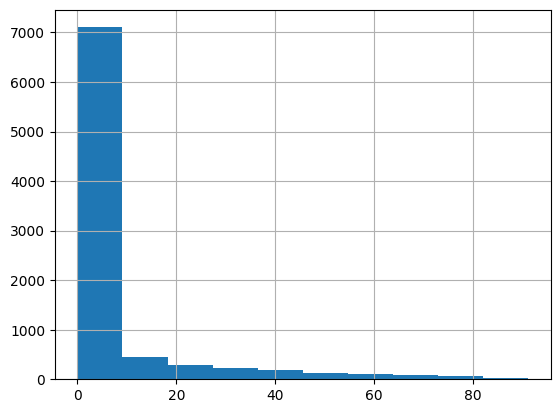

In [46]:
sub.extent.hist()

In [49]:
sub.to_csv(f'sub_{CONF.model_name}_cv{10.89}5folds.csv',index=False)

In [ ]:
from IPython.display import FileLink
FileLink(f'sub_{CONF.model_name}_cv{sc}.csv')

